In [49]:
import json
import pandas as pd
import random
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from collections import Counter
from scipy.stats.mstats import winsorize
import re

In [6]:
def read_file(filepath):
    data = []
    with open(filepath, 'r', errors='replace') as file:
        for line in file:
            try:
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError:
                pass
    return data


In [7]:
review_data = pd.DataFrame(read_file('yelp_academic_dataset_review.json'))
business_data = pd.DataFrame(read_file('yelp_academic_dataset_business.json'))

In [ ]:
# read the labeld data
label_df=pd.read_csv('C:/Users/yun13369/Downloads/540/df_test_labeled.csv')

In [ ]:
label_df.head()

In [ ]:
label_df.shape

In [8]:
print("Review Data Info:")
print(review_data.info())

# Display basic information about the 'business_data'
print("\nBusiness Data Info:")
print(business_data.info())

Review Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB
None

Business Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-n

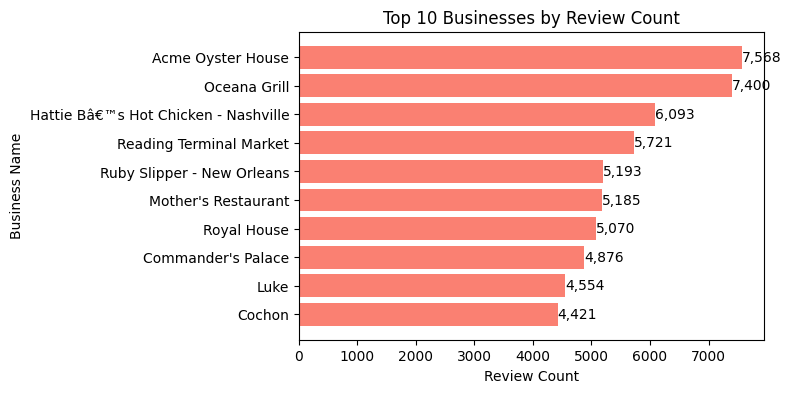

In [9]:
top_businesses = business_data.nlargest(10, 'review_count')[::-1]

# Plot the top 10 businesses
plt.figure(figsize=(6, 4))
bars = plt.barh(top_businesses['name'], top_businesses['review_count'], color='salmon')
plt.title('Top 10 Businesses by Review Count')
plt.xlabel('Review Count')
plt.ylabel('Business Name')

# Add business names on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}', ha='left', va='center')

plt.show()

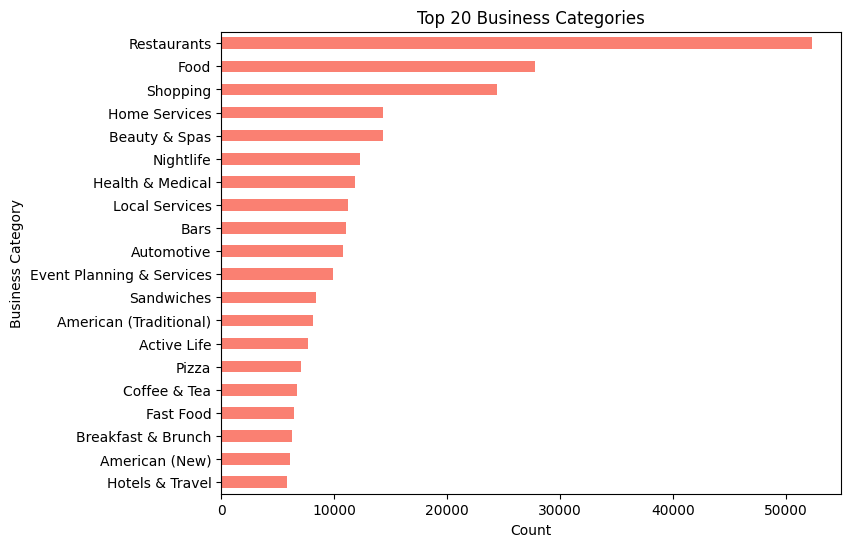

In [10]:
# Split categories and count unique values
categories_split = business_data['categories'].str.split(', ', expand=True).stack()
# Count and sort the values
category_counts = categories_split.value_counts()
plt.figure(figsize=(8, 6))
category_counts.head(20)[::-1].plot(kind='barh', color='salmon')  # Reverse the order
plt.title('Top 20 Business Categories')
plt.xlabel('Count')
plt.ylabel('Business Category')
plt.show()

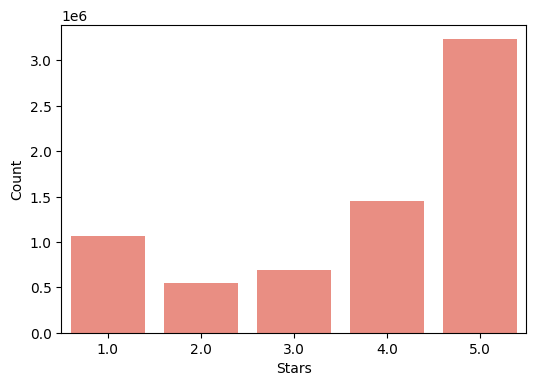

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x='stars', data=review_data, color='salmon')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

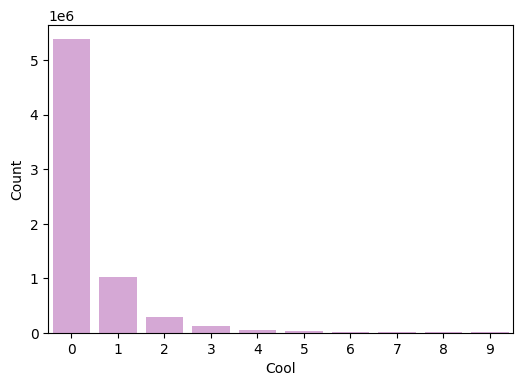

In [12]:
cool_column = review_data['cool']
cool_column = cool_column[(cool_column < 10) & (cool_column > -1)]

plt.figure(figsize=(6, 4))
sns.countplot(x=cool_column, color='plum')
plt.xlabel('Cool')
plt.ylabel('Count')
plt.show()

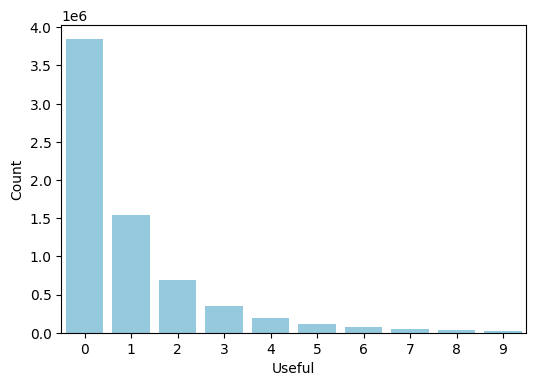

In [13]:
useful_column = review_data['useful']
useful_column = useful_column[(useful_column < 10) & (useful_column > -1)]

plt.figure(figsize=(6, 4))
sns.countplot(x=useful_column, color='skyblue')
plt.xlabel('Useful')
plt.ylabel('Count')
plt.show()

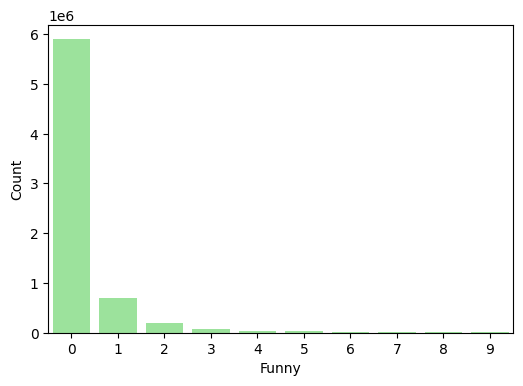

In [14]:
funny_column = review_data['funny']
funny_column = funny_column[(funny_column < 10) & (funny_column > -1)]

plt.figure(figsize=(6, 4))
sns.countplot(x=funny_column, color='lightgreen')
plt.xlabel('Funny')
plt.ylabel('Count')
plt.show()

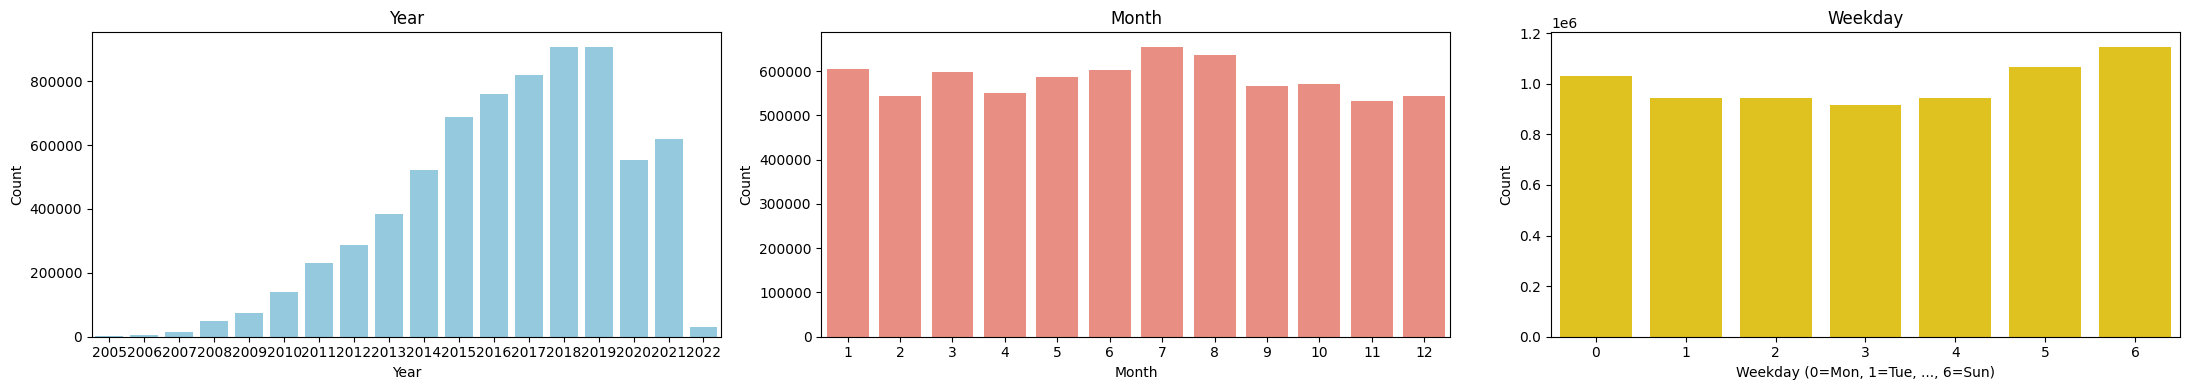

In [15]:
review_data['date'] = pd.to_datetime(review_data['date'])

# Extract year, month, day, and weekday for analysis
review_data['year'] = review_data['date'].dt.year
review_data['month'] = review_data['date'].dt.month
review_data['day'] = review_data['date'].dt.day
review_data['weekday'] = review_data['date'].dt.weekday  # Monday is 0 and Sunday is 6

# Plot the distribution of reviews over the years, months, days of the month, and weekdays in a single row
fig, axes = plt.subplots(1, 3, figsize=(22, 4))

# Plot for the distribution of reviews over the years
sns.countplot(x='year', data=review_data, color='skyblue', ax=axes[0])
axes[0].set_title('Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')

# Plot for the distribution of reviews over months
sns.countplot(x='month', data=review_data, color='salmon', ax=axes[1])
axes[1].set_title('Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

# Plot for the weekdays
sns.countplot(x='weekday', data=review_data, color='gold', ax=axes[2])
axes[2].set_title('Weekday')
axes[2].set_xlabel('Weekday (0=Mon, 1=Tue, ..., 6=Sun)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [16]:
df_full = review_data.join(business_data.set_index('business_id'), on='business_id', rsuffix='_business')
filtered_df = df_full[df_full['categories'].str.contains("Restaurant", na=False)]
labeled_id=pd.read_excel('labeled_review_id.xlsx')
filtered_df = filtered_df[~filtered_df['review_id'].isin(labeled_id['review_id'])]
filtered_df = filtered_df[['review_id','stars','useful', 'funny', 'cool', 'text', 'categories']]

sample_size = 1000000
filtered_df = filtered_df.sample(n=sample_size, random_state=42)


In [17]:
numerical_columns = ['useful', 'funny', 'cool']

# Apply winsorization to each numerical column
for column in numerical_columns:
    # Winsorize the column, replacing extreme values with values within the specified limits
    filtered_df[column] = winsorize(filtered_df[column], limits=[0.05, 0.05])

In [18]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 5329117 to 4449709
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   review_id   1000000 non-null  object 
 1   stars       1000000 non-null  float64
 2   useful      1000000 non-null  int64  
 3   funny       1000000 non-null  int64  
 4   cool        1000000 non-null  int64  
 5   text        1000000 non-null  object 
 6   categories  1000000 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 61.0+ MB


In [19]:
filtered_df.head(20)

,review_id,stars,useful,funny,cool,text,categories
5329117,ZRRSVXNw3jR66lY_Iz9DDQ,1.0,0,0,0,Just left this restaurant......BEWARE....order...,"Restaurants, Steakhouses"
3210962,9nGyZKtYxkR6zi6laHtEdg,1.0,1,0,0,Updating my previous review of this location.....,"Restaurants, Sandwiches, Salad, Soup"
1410338,urPoX4vS6p5a7yDrMkGIeQ,4.0,1,1,1,Pretty outdoor mall right in the heart of Stat...,"American (Traditional), Restaurants, Shopping ..."
5587486,0IaehZ_ujUHyfAoKul8-aw,2.0,2,1,2,"Yeah, I was not impressed by this place at all...","Bars, American (New), Restaurants, Nightlife, ..."
3069741,m-23Loxm1O0Vd5HLHs7i3g,5.0,1,0,0,Some of the best pizza we've had. Awesome ing...,"Pizza, Restaurants, Italian"
1117225,_NgFaM6GtuOcMP9gfjGKyQ,1.0,0,0,0,literally a joke in regards to service. the pi...,"Restaurants, Wraps, Food, Pizza, Salad"
5653779,0rnEvjI9lZLvM4ri4PoMhQ,3.0,0,0,0,Spent a few hours here to wrap up our Mother's...,"Bars, Nightlife, Tapas/Small Plates, Tapas Bar..."
6281297,M6ROahdA7phsxqrx1mvyYw,4.0,4,1,2,"For my Combo Plate, I chose the Chicken Katsu ...","Caterers, Hawaiian, Restaurants, Burgers, Barb..."
1027281,Y7HxYn0QuU0LtsxXDperSw,3.0,4,2,2,It was good. AND SO MUCH FUN!\nI took the bf f...,"Seafood, Steakhouses, Brazilian, Restaurants"
6530348,RShxknksF-RuSLXPLHh40A,2.0,0,0,0,"Pretty fair to say, based on past reviews that...","Japanese, Restaurants"


In [20]:
translator = str.maketrans('', '', string.punctuation)

def preprocess_text(text):

    text = text.translate(translator)
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

In [21]:
filtered_df['cleaned_text'] = filtered_df['text'].apply(preprocess_text)

In [22]:
unwanted_words = ['food', 'good', 'great', 'us']

filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('food ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('good ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('great ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('place ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('order ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace(' us ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.strip()

In [23]:
filtered_df

,review_id,stars,useful,funny,cool,text,categories,cleaned_text
5329117,ZRRSVXNw3jR66lY_Iz9DDQ,1.0,0,0,0,Just left this restaurant......BEWARE....order...,"Restaurants, Steakhouses",left restaurantbewareordered steaksfilet lobst...
3210962,9nGyZKtYxkR6zi6laHtEdg,1.0,1,0,0,Updating my previous review of this location.....,"Restaurants, Sandwiches, Salad, Soup",updating previous review location im really di...
1410338,urPoX4vS6p5a7yDrMkGIeQ,4.0,1,1,1,Pretty outdoor mall right in the heart of Stat...,"American (Traditional), Restaurants, Shopping ...",pretty outdoor mall right heart state street s...
5587486,0IaehZ_ujUHyfAoKul8-aw,2.0,2,1,2,"Yeah, I was not impressed by this place at all...","Bars, American (New), Restaurants, Nightlife, ...",yeah impressed inside dark sparsely decorated ...
3069741,m-23Loxm1O0Vd5HLHs7i3g,5.0,1,0,0,Some of the best pizza we've had. Awesome ing...,"Pizza, Restaurants, Italian",best pizza weve awesome ingredients nice crust...
...,...,...,...,...,...,...,...,...
4680360,KqiA_5vtVYdGxce8bZkqbg,2.0,0,0,0,They skimp on filling your bowl up unlike othe...,"Mexican, Fast Food, Restaurants",skimp filling bowl unlike chipotles area also ...
3119808,SJem7Q2F8inCL0-ju-WQsw,5.0,0,0,0,This was a great place. The servers were great...,"Restaurants, Cajun/Creole, Seafood",servers friendly started blueberry salad fanta...
582662,WHa3LpPGlz712AKACv4LJQ,5.0,2,1,1,AMAZING food and ambiance. Would love to go ag...,"Active Life, Beer Gardens, Grocery, Middle Eas...",amazing ambiance would love go highly suggest ...
6644498,EilucjGcse6yDIy0G3P3YQ,2.0,0,0,0,Went in for a late dinner and some drinks. Foo...,"Beauty & Spas, Massage, Hair Salons, Restauran...",went late dinner drinks mediocre drinks taste ...


In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['cleaned_text'])

In [25]:
numeric_columns = ['stars', 'useful', 'funny', 'cool']
numeric_data = filtered_df[numeric_columns].values

In [26]:
combined_matrix = hstack([tfidf_matrix, numeric_data])

scaler = StandardScaler(with_mean=False, with_std=True)
combined_matrix = scaler.fit_transform(combined_matrix)

In [27]:
svd = TruncatedSVD(n_components=100)
svd.fit(combined_matrix)
svd_data = svd.transform(combined_matrix)

In [28]:
feature_names = tfidf_vectorizer.get_feature_names_out()

In [82]:
def plot_top_words_per_cluster_wordcloud(cluster_words):
    num_clusters = len(cluster_words)

    fig, axs = plt.subplots(1, num_clusters, figsize=(3 * num_clusters, 2))
    fig.suptitle('Top Words for Each Cluster (WordCloud)', fontsize=16)

    for cluster, top_words in cluster_words.items():
        ax = axs[cluster] if num_clusters > 1 else axs  # Handle single-cluster case

        # Create a WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Cluster {cluster}', fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [94]:
def get_top_words_and_categories_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10):
    cluster_words = {}
    cluster_categories = {}

    for cluster in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get top words
        cluster_tfidf = tfidf_matrix[cluster_indices].sum(axis=0)
        top_indices = cluster_tfidf.argsort()[0, ::-1][:n_words]
        top_words = [str(feature_names[i]) for i in top_indices]
        cluster_words[cluster] = top_words

        # Get top categories
        categories_words = filtered_df['categories'].iloc[cluster_indices]
        all_categories = ','.join(categories_words).replace(' Restaurants,', '').split(',')
        word_counts = Counter(all_categories)
        top_categories = word_counts.most_common(10)
        cluster_categories[cluster] = top_categories
        
        print(top_words)
        print(top_categories)

    return cluster_words, cluster_categories


["[['minutes' 'service' 'time' ... 'bursting' 'lavender' 'choy']]"]
[(' Nightlife', 42117), (' Bars', 41164), ('Restaurants', 40184), (' Food', 35470), (' American (Traditional)', 33966), (' American (New)', 27516), (' Breakfast & Brunch', 22609), (' Burgers', 18301), (' Sandwiches', 17655), (' Seafood', 15416)]
["[['service' 'best' 'friendly' ... 'scrambled' 'rudely' 'gallo']]"]
[(' Nightlife', 131786), (' Bars', 127993), ('Restaurants', 121921), (' Food', 119970), (' American (Traditional)', 86453), (' American (New)', 84063), (' Breakfast & Brunch', 63306), (' Sandwiches', 60770), (' Seafood', 55462), (' Pizza', 42680)]
["[['tacos' 'mexican' 'salsa' ... 'turkish' 'szechuan' 'etouffee']]"]
[(' Mexican', 25868), ('Restaurants', 13606), ('Mexican', 11705), (' Bars', 9758), (' Nightlife', 9704), (' Food', 7129), (' Breakfast & Brunch', 5095), (' Tacos', 5093), (' Tex-Mex', 4454), (' Latin American', 3141)]
["[['chicken' 'like' 'ordered' ... 'rudely' 'barista' 'baristas']]"]
[('Restauran

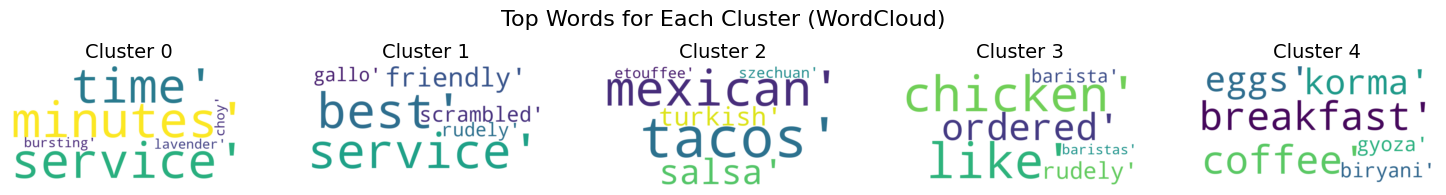

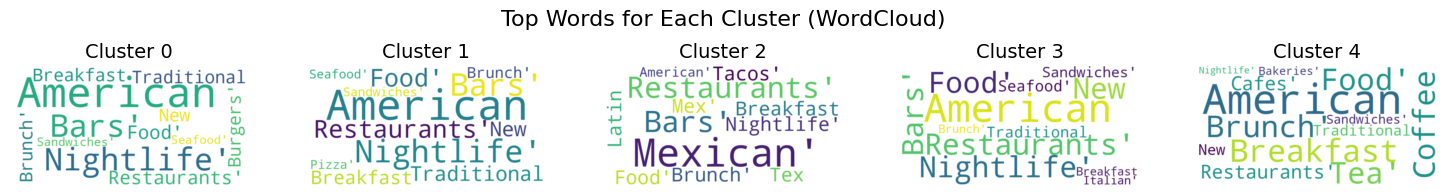

In [95]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10, max_iter=500)
cluster_labels = kmeans.fit_predict(svd_data)

cluster_words, cluster_categories = get_top_words_and_categories_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10)
formatted_output = {}

for cluster, categories_list in cluster_categories.items():
    top_categories = [category[0].strip() for category in categories_list[:10]]
    formatted_output[cluster] = [str(top_categories)]
    
plot_top_words_per_cluster_wordcloud(cluster_words)
plot_top_words_per_cluster_wordcloud(formatted_output)

In [1]:
def get_top_words_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10):

    cluster_words = {}

    for cluster in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_tfidf = tfidf_matrix[cluster_indices].sum(axis=0)
        top_indices = cluster_tfidf.argsort()[0, ::-1][:n_words]
        top_words = [str(feature_names[i]) for i in top_indices]
        cluster_words[cluster] = top_words

    return cluster_words

In [2]:
k_values = list(range(2, 10))
silhouette_scores = []

for i, k in enumerate(k_values):
    print(f'Cluster {k} start')

    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=500)
    cluster_labels = kmeans.fit_predict(svd_data)

    print(f'Cluster {k} finished')

    cluster_words=get_top_words_per_cluster(tfidf_matrix, cluster_labels, feature_names)
    plot_top_words_per_cluster_wordcloud(cluster_words)

Cluster 2 start


NameError: name 'KMeans' is not defined

In [ ]:
# time series plot
def get_time_series_plot(k,df):
# k is the number of optimized clusters
  df_cluster=df.copy()
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=500)
  cluster_labels = kmeans.fit_predict(svd_data)
  df_cluster['cluster']=cluster_labels
  df_cluster['date'] = pd.to_datetime(df_cluster['date'])
  labels=['food_quality','environment','service','convenience','cost_effectiveness']

  # Create a matrix of subplots
  fig, axes = plt.subplots(k, len(labels), figsize=(15, 15), sharex=True, sharey=True)

  for c in range(k):
      # for each cluster, plot the trend for five labels
      # NEED PREPROCESSING OF TIME HERE,use month
      df_cluster['monthly_time']=df_cluster['date'].dt.to_period('M')
      df_cluster['quater_time']=df_cluster['date'].dt.to_period('Q')
      df_cluster=df_cluster.sort_values(by='quater_time')

      for i, label in enumerate(labels):
          # Create a pivot table to get counts for each category and quarter
          pivot_table = df_cluster[df_cluster['cluster'] == c].pivot_table(index='quater_time', columns=label, aggfunc='size', fill_value=0)
          # Calculate percentage distribution
          percentage_distribution = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

          # Plot on the corresponding subplot as stacked bar
          bottom = 0
          for col in percentage_distribution.columns:
              axes[c, i].bar(percentage_distribution.index.astype(str), percentage_distribution[col], label=col, bottom=bottom)
              bottom += percentage_distribution[col]

          axes[c, i].set_title('Cluster ' + str(c + 1) + ': ' + label)
          axes[c, i].legend()

          # Customize x-axis labels
          axes[c, i].tick_params(axis='x', rotation=45, labelsize=7)  # Rotate labels by 45 degrees, set fontsize

          # Set x-axis ticks at the bottom of each plot
          axes[c, i].xaxis.set_ticks_position('bottom')

          # Set x-axis ticks to unique quarter values
          unique_quarters = df_cluster['quater_time'].unique()
          axes[c, i].set_xticks(range(len(unique_quarters)))
          axes[c, i].set_xticklabels(unique_quarters.astype(str))

          # Adjust x-axis ticks based on desired frequency (e.g., every 2 quarters)
          ticks = axes[c, i].get_xticks()
          new_ticks = [ticks[i] for i in range(0, len(ticks), 5)]
          axes[c, i].set_xticks(new_ticks)

  # Set common labels
  for ax in axes.flat:
      ax.set(xlabel='Time', ylabel='Percentage')

  # Adjust layout
  plt.tight_layout()
  plt.show()

In [ ]:
get_time_series_plot(5,filtered_df)